# COVID Fake News Classification with RCNN (Model 1)

In [1]:
import io
import json
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

## Preprocessing the Text Data

In [2]:
data = pd.read_csv('/raid/tft-data/data-covid/covid_combined.csv')

# converting labels from strings to ints
data["label"].replace({"Real": 1, "Fake": 0}, inplace=True)
data = data.fillna(' ')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17894 entries, 0 to 17893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   17894 non-null  object
 1   label   17894 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.7+ KB


In [3]:
# Tokenizing Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['title'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
max_seq_length = 80

# Padding data
# Keras prefers inputs to be vectorized and all inputs to have the same length. 
# We will pad all input sequences to have the lengthWe will pad all input sequences to have specific length
sequences = tokenizer.texts_to_sequences(data['title'])
padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [4]:
# Compartmentalizing data into training set and testing set
X = padded
y = data['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
# Using Pre-Trained GloVe for Keras embedding layer
embeddings_index = {};
with open('/raid/tft-data/Glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


## Defining and Training the Model

In [6]:
# Temporary model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Training model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_valid, y_valid))


print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1182900   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

## Visualizing the Results

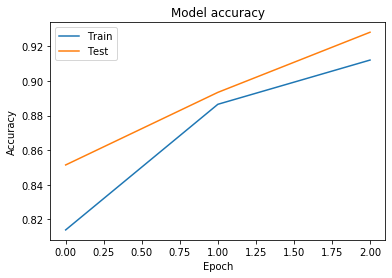

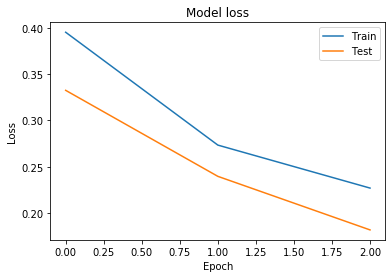

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Confusion Matrix 

In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

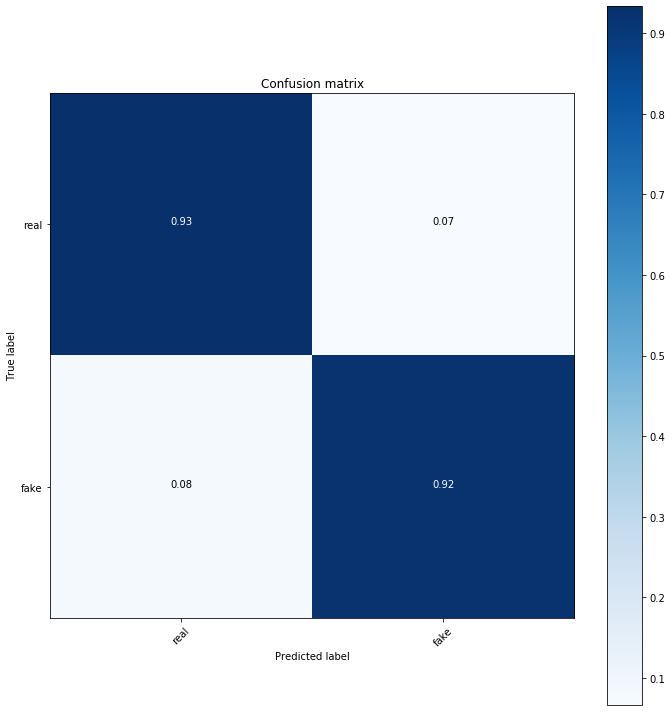

[[1275   91]
 [  89 1050]]


In [9]:
class_names = ['real', 'fake']
# compute confusion matrix
y_pred = model.predict_classes(X_valid)
cnf_matrix = confusion_matrix(y_valid, y_pred)
np.set_printoptions(precision=2)

# plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

print(cnf_matrix)

### Validation Data Results

In [10]:
print('Classification Report:')
print(classification_report(y_valid, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9348    0.9334    0.9341      1366
           1     0.9202    0.9219    0.9211      1139

    accuracy                         0.9281      2505
   macro avg     0.9275    0.9276    0.9276      2505
weighted avg     0.9282    0.9281    0.9281      2505



### Testing Data Results

In [11]:
print('Testing Results:')
y_pred_test = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_test))

Testing Results:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2961
           1       0.91      0.92      0.92      2408

    accuracy                           0.92      5369
   macro avg       0.92      0.92      0.92      5369
weighted avg       0.92      0.92      0.92      5369



## Exporting the Model

In [12]:
# Save the Tokenizer for this model
tokenizer_json = tokenizer.to_json()
with io.open('covid1-tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
# Save the Model
model.save("covid-model-1")

INFO:tensorflow:Assets written to: covid-model-1/assets


INFO:tensorflow:Assets written to: covid-model-1/assets
